## PCA and MNIST

In this notebook I will apply Principal Component Analysis several times to the MNIST dataset suing a simple Neural Network

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

import matplotlib.style #Style 
import matplotlib as mpl 
import random
from tqdm import tqdm
from scipy import linalg



#Set default figure size
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Tensorflow version
print(tf.__version__)

2023-02-23 11:07:28.222212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0


1. Train a neural network on the MNIST training dataset that achieves acceptable performance on the test dataset (>95% accuracy)

In [2]:
#load dataset
mnist= keras.datasets.mnist
(train_img,train_lbl),(test_img,test_lbl)=mnist.load_data()

#normalize both the training and testing images
train_img=train_img/np.max(train_img)
test_img=test_img/np.max(test_img)

#shape of datasets:
print('How many Images in training dataset: ',train_img[:,0,0].shape)
print('Shape of train labels: ',train_lbl.shape[0])#makes sense they should match
print('How many Images in testing dataset: ',test_img[:,0,0].shape)
print('Shape of test labels: ',test_lbl.shape[0])#makes sense they should match
print('Each image has ',train_img[0,0].shape[0],'pixels x ',train_img[0,1].shape[0],'pixels')


How many Images in training dataset:  (60000,)
Shape of train labels:  60000
How many Images in testing dataset:  (10000,)
Shape of test labels:  10000
Each image has  28 pixels x  28 pixels


## 1) MNIST dataset NN (98% acc)

In [52]:
#BUILD NEURAL NETWORK
mnist =keras.Sequential()
#initial layer
mnist.add(keras.layers.Flatten(input_shape=(28,28)))
#Dense layers
mnist.add(keras.layers.Dense(32, activation='relu'))
#final output can be 10 numbers so 10 output nodes
mnist.add(keras.layers.Dense(10))

The Neural Network could be way more simpler but in this project I wanted to test a relatively more complex neural network.

In [66]:
mnist.summary()
#Compile with SparseCategoricalCrossentropy and Stochastic Gradient descent (ADAM could be another good option)
mnist.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_16 (Dense)            (None, 32)                25120     
                                                                 
 dense_17 (Dense)            (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [67]:
#Batchsize of a 100 over 15 epochs
history = mnist.fit(train_img,train_lbl,batch_size=100,epochs=15,verbose=1, validation_data=(test_img, test_lbl))


Epoch 1/15
600/600 [==============================] - 3s 4ms/step - loss: 0.0810 - accuracy: 0.9740 - val_loss: 0.1853 - val_accuracy: 0.9581
Epoch 2/15
600/600 [==============================] - 2s 3ms/step - loss: 0.0763 - accuracy: 0.9755 - val_loss: 0.1693 - val_accuracy: 0.9620
Epoch 3/15
600/600 [==============================] - 2s 3ms/step - loss: 0.0788 - accuracy: 0.9755 - val_loss: 0.1743 - val_accuracy: 0.9632
Epoch 4/15
600/600 [==============================] - 2s 3ms/step - loss: 0.0695 - accuracy: 0.9780 - val_loss: 0.1699 - val_accuracy: 0.9626
Epoch 5/15
600/600 [==============================] - 2s 3ms/step - loss: 0.0705 - accuracy: 0.9782 - val_loss: 0.1769 - val_accuracy: 0.9624
Epoch 6/15
600/600 [==============================] - 2s 4ms/step - loss: 0.0656 - accuracy: 0.9790 - val_loss: 0.1990 - val_accuracy: 0.9559
Epoch 7/15
600/600 [==============================] - 2s 3ms/step - loss: 0.0690 - accuracy: 0.9785 - val_loss: 0.1946 - val_accuracy: 0.9580
Epoch 

In [68]:
test_loss,test_acc=mnist.evaluate(test_img, test_lbl)# store loss and accuracy

313/313 [==============================] - 1s 3ms/step - loss: 0.2013 - accuracy: 0.9622


Text(0, 0.5, 'accuracy')

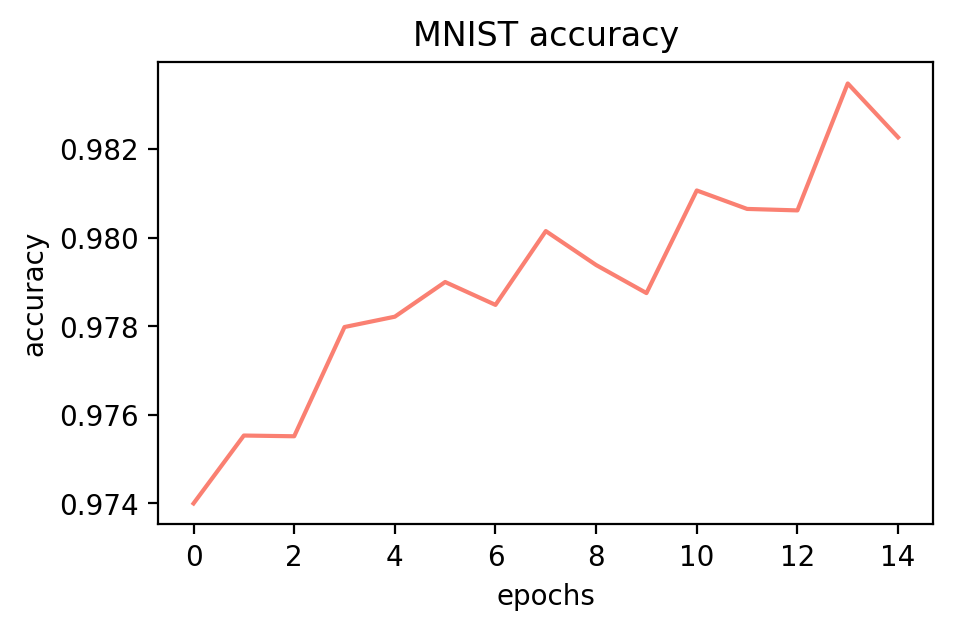

In [150]:
#simple plot of accuracy fo our NN over epochs
fig,ax=plt.subplots(figsize=(5,3))
ax.plot(history.history['accuracy'],color='salmon')
ax.set_title('MNIST accuracy')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')

## 2) Decomposing the MNIST data into its PCA components

In [70]:
def eigencov(data_img):
    
    '''
    This function takes a set of image 
    data(train,test,validation or any dataset)
    Centers it and calculates teh eigenvectors and
    eigenvalues
    ----------------------------------------------
    Parameters: 
        data_img ---> the dataset being evaluated 
    
    '''
    
    n_img=len(data_img[:,0,0])#for RGB images
    #Reshape to 2D
    X=np.reshape(data_img,(n_img,28*28))#if images are 28x28 pixels
    
    #Taking the mean and substracting it to get center data
    mu=np.mean(X,axis=0)
    x=X-mu    #data center
    
    #Covariance matrix (uses the variance of the center data)
    # this matrix would trasnform any vector to one closer to the eigenvectors
    rho=np.cov(x,rowvar=False)
    
    #Get eigenvalues and eigenvectors
    eigvalue, eigvector=linalg.eigh(rho)
    #Vals is a 1-D array of the eigenvalues in ascending order, vecs is a columnwise array of the normalised
    # eigenvectors such that vecs[:,i] is the eigenvector correspondong to vals[i]
    eigvalue=np.flip(eigvalue)
    eigvector=np.flip(eigvector)
    
    return eigvalue, eigvector, x, mu

In [71]:
#Eigenvalues and eigenvectors of the train data images
eigval_train,eigvec_train, x, mu_train = eigencov(train_img)#store

print(f'eigenvalues shape: {np.shape(eigval_train)}')
print(f'eigenvectors shape: {np.shape(eigvec_train)}')

eigenvalues shape: (784,)
eigenvectors shape: (784, 784)


## View of dataset now

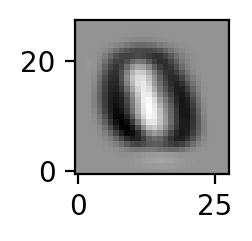

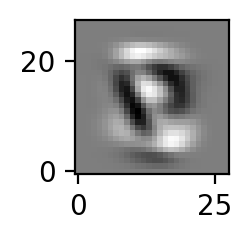

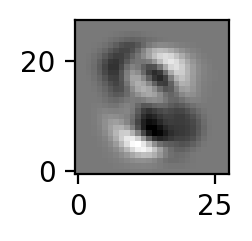

In [151]:
#Simple plot of images with eigenvectors
for i in range(3):
    fig, ax=plt.subplots(figsize=(1,1))
    ax.imshow(np.reshape(eigvec_train[:,i],[28,28]),origin='lower',cmap='binary',interpolation='nearest')

In [73]:
#possible plot of PCA index vs variance

## 3) Using the Best $N$ components

Having determined all of the eigenvectors we can now try to reconstruct our image using only a subset of the eigenvectors. 
We will be constructing a projection operator to do something close to
$$y = V^T V x$$

where V^T is the transpose of the eigenvector matrix and x is the dataset

Doing this below for all 60,000 of the training images the order of the matrices in the dot products can look a little confusing.
$$ P = x v $$
$$ y = P v^T $$
and in this last line we can either compute the matrix multiplication over the full matrix (to recover x) or over the first $N$ columns of $P$ and rows of $v^T$.

In [74]:
#Get eigenvalues and eigenvectors of the center image test as well as the center test images
eigval_test, eigvec_test, y, mu = eigencov(test_img)

In [113]:
def best_N_PCA(model,n,y,eigenvectors,lbl,mu):
    '''
    Given a model and a number of components
    creates n datasets and tests teh accuracy of model
    --------------------------------------------------
    Parameters: 
        model ---->  The model of NN
        n     ---->  Maximum number of data in N-pca
        y     ---->  Dataset
        eigenvectors ----> Eigenvectors 
        lbl   ---->  Labels of the data
        mu    ---->  Mean of dataset
    '''
    
    #Storage
    acc_stor = np.zeros(n) 
    #Array of length n of N-PCA components
    N=np.linspace(1,784,num=n,dtype=int)

    #Projection of data
    for i in tqdm(range(n)):
        P = np.dot(y,eigenvectors)#Projections
        #n-PCA images Py*ν where ν is the transpose of eigenvectors matrix
        n_pca=(np.dot(P[:,0:N[i]],eigenvectors.T[0:N[i],:]))+mu #mu added back to get bakc the original images
        #evaluation
        loss, acc = model.evaluate(n_pca,lbl,verbose=0)
        #fill storage
        acc_stor[i]=acc
    return acc_stor,N, n_pca

In [114]:
#MNIST dataset accuracy of best N_PCA components
acc_test,N_test,n_PCA =best_N_PCA(mnist,100,y,eigvec_test,test_lbl,mu)

100%|█████████████████████████████████████████| 100/100 [01:55<00:00,  1.16s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


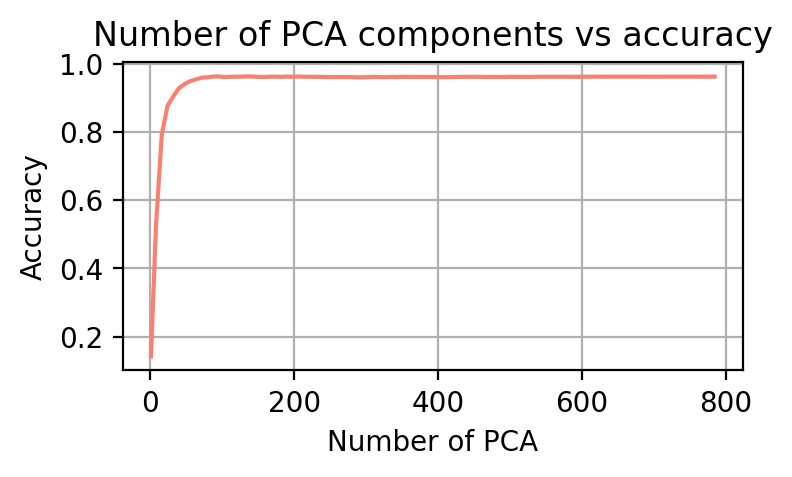

In [116]:
fig,ax=plt.subplots(figsize=(4,2))
ax.plot(N_test,acc_test,color='salmon')
ax.set_title('Number of PCA components vs accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of PCA')
ax.legend()
ax.grid()

### Comments
As we can see the accuracy jumps really fast to about a value of 0.9 and then it becomes relatively constant changing slightly around that value over the 784 NPCA

## 4) Using the 100-best PCA components to make a new training dataset 
Using the 60000 MNIST training images we will retrain the NN (mnist)
(using the 60,000 MNIST training images) and retrain your neural network from 1)
The first thing would be create new data using the projections of the 100 best PCA components in this case the first 100 adn reshape it to 3D.
And to retrain lets recreate the neural network from before, in this case called mnist_100.

In [118]:
#Create new data usign the projections
P=np.dot(x,eigvec_train)
N_PCA100=(np.dot(P[:,0:100],eigvec_train.T[0:100,:]))+mu_train
#Reshape (back to 28x28 pixels)
N_PCA100=np.reshape(N_PCA100,(60000,28,28))

#Same model as before
mnist_100 =keras.Sequential()
#initial layer
mnist_100.add(keras.layers.Flatten(input_shape=(28,28)))
#Dense layers
mnist_100.add(keras.layers.Dense(32, activation='relu'))
#final output can be 10 numbers so 10 output nodes
mnist_100.add(keras.layers.Dense(10))

#Compile with SparseCategoricalCrossentropy and Stochastic Gradient descent (ADAM could be another good option)
mnist_100.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
              metrics=['accuracy'])

In [119]:
history_100 = mnist_100.fit(N_PCA100,train_lbl,batch_size=100,epochs=15,verbose=1, validation_data=(test_img, test_lbl))

Epoch 1/15
600/600 [==============================] - 4s 5ms/step - loss: 0.6273 - accuracy: 0.8043 - val_loss: 0.3261 - val_accuracy: 0.9020
Epoch 2/15
600/600 [==============================] - 2s 4ms/step - loss: 0.3351 - accuracy: 0.9024 - val_loss: 0.2591 - val_accuracy: 0.9225
Epoch 3/15
600/600 [==============================] - 2s 3ms/step - loss: 0.2750 - accuracy: 0.9209 - val_loss: 0.2506 - val_accuracy: 0.9273
Epoch 4/15
600/600 [==============================] - 2s 3ms/step - loss: 0.2351 - accuracy: 0.9326 - val_loss: 0.2285 - val_accuracy: 0.9311
Epoch 5/15
600/600 [==============================] - 2s 4ms/step - loss: 0.2236 - accuracy: 0.9352 - val_loss: 0.2353 - val_accuracy: 0.9317
Epoch 6/15
600/600 [==============================] - 2s 3ms/step - loss: 0.2140 - accuracy: 0.9376 - val_loss: 0.1923 - val_accuracy: 0.9421
Epoch 7/15
600/600 [==============================] - 2s 3ms/step - loss: 0.2103 - accuracy: 0.9382 - val_loss: 0.2189 - val_accuracy: 0.9390
Epoch 

In [80]:
#Store accuracy and PCA components
acc_100,N_100,n_PCA_100=best_N_PCA(mnist_100,100,y,eigvec_test,test_lbl,mu)

100%|█████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


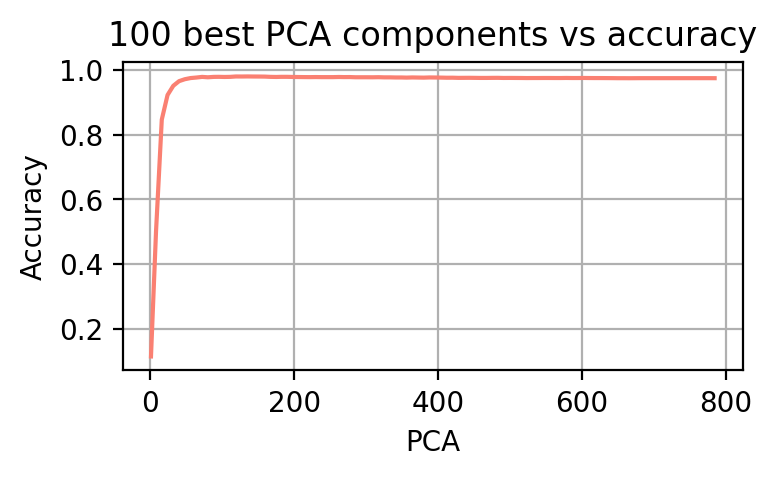

In [81]:
fig,ax=plt.subplots(figsize=(4,2))
ax.plot(N_100,acc_100,color='salmon')

ax.set_title('100 best PCA components vs accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('PCA')
ax.legend()
ax.grid()

## 6) Now with only the Best 20 components


In [142]:
#Create new data
P=np.dot(x,eigvec_train)
N_PCA20=(np.dot(P[:,0:20],eigvec_train.T[0:20,:]))+mu_train
#Reshape (back to 28x28 pixels)
N_PCA20=np.reshape(N_PCA100,(60000,28,28))

#Retrained over 20 PCA
mnist_20 =keras.Sequential()
#initial layer
mnist_20.add(keras.layers.Flatten(input_shape=(28,28)))
#Dense layers
mnist_20.add(keras.layers.Dense(32, activation='relu'))
#final output can be 10 numbers so 10 output nodes
mnist_20.add(keras.layers.Dense(10))

#Compile
mnist_20.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam',
              metrics=['accuracy'])

In [143]:
history_20 = mnist_20.fit(N_PCA20,train_lbl,batch_size=100,epochs=15,verbose=1, validation_data=(test_img, test_lbl))


Epoch 1/15
600/600 [==============================] - 6s 7ms/step - loss: 0.4829 - accuracy: 0.8697 - val_loss: 0.2659 - val_accuracy: 0.9239
Epoch 2/15
600/600 [==============================] - 3s 4ms/step - loss: 0.2440 - accuracy: 0.9304 - val_loss: 0.2252 - val_accuracy: 0.9329
Epoch 3/15
600/600 [==============================] - 2s 4ms/step - loss: 0.2025 - accuracy: 0.9415 - val_loss: 0.1989 - val_accuracy: 0.9408
Epoch 4/15
600/600 [==============================] - 2s 3ms/step - loss: 0.1785 - accuracy: 0.9476 - val_loss: 0.1758 - val_accuracy: 0.9461
Epoch 5/15
600/600 [==============================] - 2s 4ms/step - loss: 0.1608 - accuracy: 0.9525 - val_loss: 0.1636 - val_accuracy: 0.9508
Epoch 6/15
600/600 [==============================] - 2s 4ms/step - loss: 0.1472 - accuracy: 0.9572 - val_loss: 0.1569 - val_accuracy: 0.9521
Epoch 7/15
600/600 [==============================] - 2s 3ms/step - loss: 0.1350 - accuracy: 0.9604 - val_loss: 0.1463 - val_accuracy: 0.9559
Epoch 

In [144]:
acc_20, N_20, n_PCA_20=best_N_PCA(mnist_20,100,y,eigvec_test,test_lbl,mu)

100%|█████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


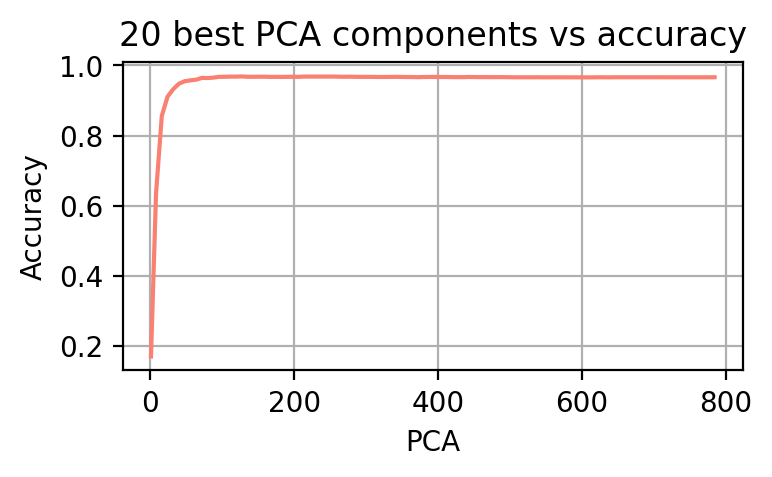

In [146]:
fig,ax=plt.subplots(figsize=(4,2))
ax.plot(N_20,acc_20,color='salmon')
ax.set_title('20 best PCA components vs accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('PCA')
ax.legend()
ax.grid()

### Plot of accuracy over epochs of the reduced PCA models

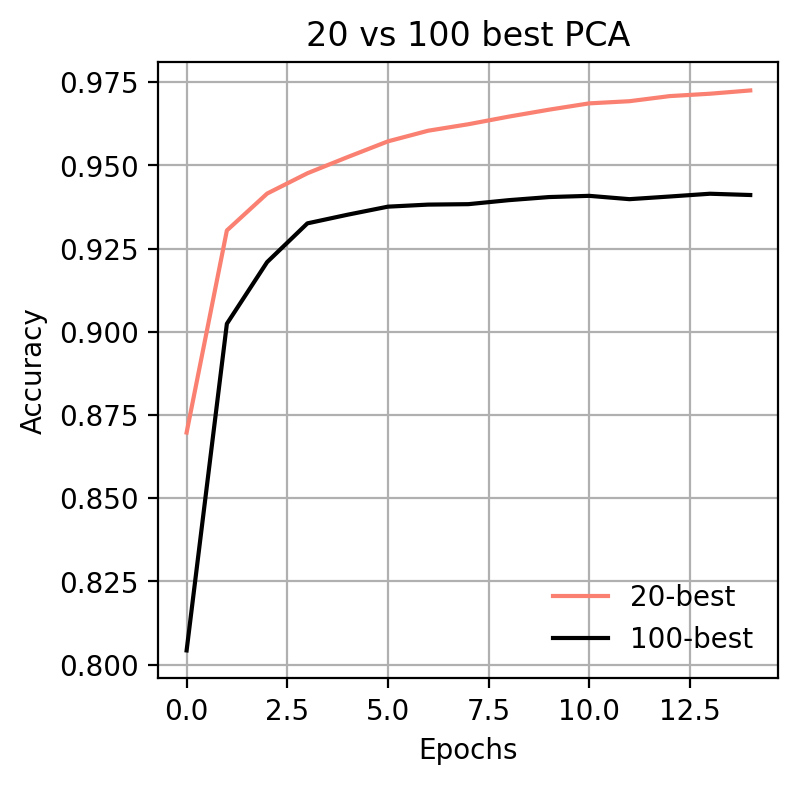

In [152]:
fig,ax=plt.subplots(figsize=(4,4))
ax.plot(history_20.history['accuracy'],color='salmon',label='20-best')
ax.plot(history_100.history['accuracy'],color='k',label='100-best')
ax.set_title('20 vs 100 best PCA')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.legend()
ax.grid()


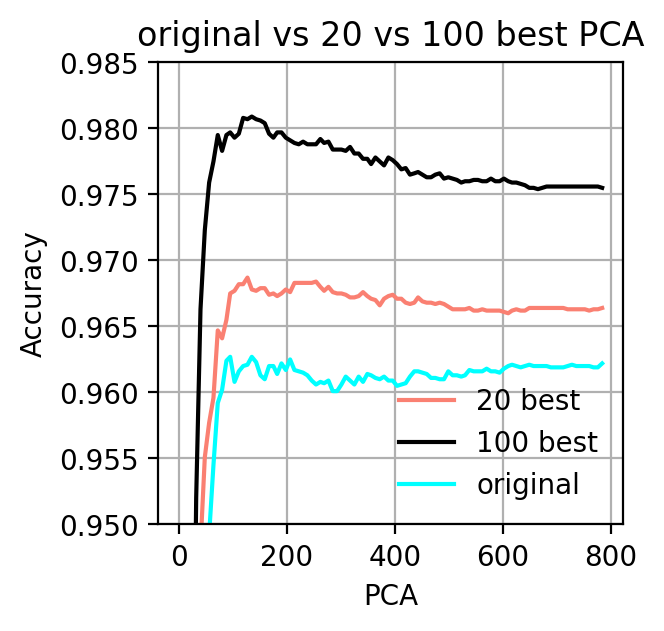

In [148]:
fig,ax=plt.subplots(figsize=(3,3))
ax.plot(N_20,acc_20,color='salmon',label='20 best')
ax.plot(N_100,acc_100,color='k',label='100 best')
ax.plot(N_test,acc_test,color='cyan',label='original')
ax.set_title('original vs 20 vs 100 best PCA')
ax.set_ylim((0.95, 0.985))
ax.set_ylabel('Accuracy')
ax.set_xlabel('PCA')
ax.legend()
ax.grid()

## COMMENTS
Based on the comparison of data, it suggests that choosing the best 100 PCs leads to better accuracy. The difference between using all components and the Best-100 PCs is only 0.02, which could potentially make a difference, and it is also more efficient.

This result indicates that the best 20 PCs do not retain enough information about the data, possibly due to capturing only a small fraction of the variability in the data. Using all the components leads to overfitting since the model becomes too complex and tries to fit to every single data point, including the noise.

Therefore, the best 100 PCs give the best accuracy.